In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv("Sample_data.csv")
df.head()

,mmsi,timestamp,lat,lon
0,565761000,2023-03-15 00:27:44+00,1.26878,103.75827
1,538008084,2023-03-19 23:30:00+00,43.55962,10.29404
2,564654000,2023-03-12 08:22:53+00,1.23725,103.89135
3,529123000,2023-03-05 16:47:42+00,29.44367,48.93066
4,564780000,2023-03-11 06:35:20+00,1.27755,103.61026


In [2]:
#Data Cleaning
#missing data
df.isna().sum()

mmsi         0
timestamp    0
lat          0
lon          0
dtype: int64

In [6]:
#no missing data.
#checking if longitude and latitude data is between -180-180 degrees
df["lat"].describe()

count    13501.000000
mean         7.096132
std         12.937516
min        -32.213560
25%          1.235940
50%          1.262690
75%          1.302477
max         50.705240
Name: lat, dtype: float64

In [7]:
df["lon"].describe()

count    13501.000000
mean        78.095846
std         53.279099
min        -89.889167
25%        103.610320
50%        103.809770
75%        103.903350
max        121.841440
Name: lon, dtype: float64

In [9]:
df.columns

Index(['mmsi', 'timestamp', 'lat', 'lon'], dtype='object')

In [22]:
##Checking the mmsi column if all the mmsi numbers are 9 digits and are positive numbers
df[df["mmsi"]<=0]

,mmsi,timestamp,lat,lon


In [ ]:
##all mmsi numbers are positive now checking the length

In [26]:
df["mmsi_len"]=df["mmsi"].apply(lambda x: len(str(x))!=9)
df["mmsi_len"].value_counts()

False    13501
Name: mmsi_len, dtype: int64

In [36]:
##all mmsi are of 9 digits

In [34]:
##rounding up longitudes and latitudes to two decimal places
df["lat"]=round(df["lat"],2)
df["lon"]=round(df["lon"],2)

In [35]:
df.head()

,mmsi,timestamp,lat,lon,mmsi_len
0,565761000,2023-03-15 00:27:44+00,1.27,103.76,False
1,538008084,2023-03-19 23:30:00+00,43.56,10.29,False
2,564654000,2023-03-12 08:22:53+00,1.24,103.89,False
3,529123000,2023-03-05 16:47:42+00,29.44,48.93,False
4,564780000,2023-03-11 06:35:20+00,1.28,103.61,False


In [30]:
#Creating a function to calculate distance using Haversine formula:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

In [31]:
haversine(1.26878,103.75827,43.55961952,10.29404048)

10189.25832177532

In [37]:
# Define a proximity threshold in kilometers
proximity_threshold = 0.5  # For example, 0.5 km

# Initialize an empty list to store the results
proximity_events = []

# Group by timestamp to compare vessels within the same time frame
for timestamp, group in df.groupby('timestamp'):
    # Compare each vessel with every other vessel in the group
    for i, vessel_1 in group.iterrows():
        vessel_proximity = []
        for j, vessel_2 in group.iterrows():
            if vessel_1['mmsi'] != vessel_2['mmsi']:
                # Calculate distance between the two vessels
                distance = haversine(vessel_1['lat'], vessel_1['lon'], vessel_2['lat'], vessel_2['lon'])
                if distance <= proximity_threshold:
                    vessel_proximity.append(vessel_2['mmsi'])
        
        # Store the result if any proximity event is found
        if vessel_proximity:
            proximity_events.append({
                'mmsi': vessel_1['mmsi'],
                'vessel_proximity': vessel_proximity,
                'timestamp': timestamp
            })


In [38]:
proximity_events

[{'mmsi': 565761000,
  'vessel_proximity': [564780000],
  'timestamp': '2023-03-04 18:30:00+00'},
 {'mmsi': 564780000,
  'vessel_proximity': [565761000],
  'timestamp': '2023-03-04 18:30:00+00'},
 {'mmsi': 564780000,
  'vessel_proximity': [563014650],
  'timestamp': '2023-03-05 07:30:00+00'},
 {'mmsi': 563014650,
  'vessel_proximity': [564780000],
  'timestamp': '2023-03-05 07:30:00+00'},
 {'mmsi': 563014650,
  'vessel_proximity': [564780000],
  'timestamp': '2023-03-05 08:30:00+00'},
 {'mmsi': 564780000,
  'vessel_proximity': [563014650],
  'timestamp': '2023-03-05 08:30:00+00'},
 {'mmsi': 564780000,
  'vessel_proximity': [563014650],
  'timestamp': '2023-03-05 09:30:00+00'},
 {'mmsi': 563014650,
  'vessel_proximity': [564780000],
  'timestamp': '2023-03-05 09:30:00+00'},
 {'mmsi': 564780000,
  'vessel_proximity': [563014650],
  'timestamp': '2023-03-05 10:30:00+00'},
 {'mmsi': 563014650,
  'vessel_proximity': [564780000],
  'timestamp': '2023-03-05 10:30:00+00'},
 {'mmsi': 564780000,

In [39]:
proximity_df = pd.DataFrame(proximity_events)
proximity_df.head(5)

,mmsi,vessel_proximity,timestamp
0,565761000,[564780000],2023-03-04 18:30:00+00
1,564780000,[565761000],2023-03-04 18:30:00+00
2,564780000,[563014650],2023-03-05 07:30:00+00
3,563014650,[564780000],2023-03-05 07:30:00+00
4,563014650,[564780000],2023-03-05 08:30:00+00


In [52]:
proximity_df["vessels_nearby"]=proximity_df["vessel_proximity"].apply(lambda x: len(x))
proximity_df[proximity_df["vessels_nearby"]>3].head(5)

,mmsi,vessel_proximity,timestamp,vessels_nearby
183,875832716,"[232006548, 889799564, 232345740, 218719092]",2023-03-15 01:30:00+00,4
184,232006548,"[875832716, 889799564, 232345740, 218719092]",2023-03-15 01:30:00+00,4
185,889799564,"[875832716, 232006548, 232345740, 218719092]",2023-03-15 01:30:00+00,4
186,232345740,"[875832716, 232006548, 889799564, 218719092]",2023-03-15 01:30:00+00,4
187,218719092,"[875832716, 232006548, 889799564, 232345740]",2023-03-15 01:30:00+00,4


In [54]:
output_df=proximity_df.drop("vessels_nearby",axis=1)

In [55]:
output_df.head(5)

,mmsi,vessel_proximity,timestamp
0,565761000,[564780000],2023-03-04 18:30:00+00
1,564780000,[565761000],2023-03-04 18:30:00+00
2,564780000,[563014650],2023-03-05 07:30:00+00
3,563014650,[564780000],2023-03-05 07:30:00+00
4,563014650,[564780000],2023-03-05 08:30:00+00


In [ ]:
#Visualising the proximity events

In [63]:
# Reproject to a projected CRS (e.g., UTM zone 33N for the area around Europe)
gdf_projected = gdf.to_crs(epsg=32633)  # You may need to choose the appropriate UTM zone

# Perform the spatial join with the reprojected GeoDataFrame
gdf_proximity_projected = sjoin_nearest(gdf_projected, gdf_projected, distance_col='distance', max_distance=proximity_threshold)

# Filter out self-joins (same MMSI)
gdf_proximity_projected = gdf_proximity_projected[gdf_proximity_projected['mmsi_left'] != gdf_proximity_projected['mmsi_right']]


In [64]:
# Merge the proximity_events DataFrame with the original GeoDataFrame to get the geometries
proximity_gdf = proximity_events.merge(gdf_projected[['mmsi', 'geometry']], left_on='mmsi', right_on='mmsi')

# Convert it to a GeoDataFrame
proximity_gdf = gpd.GeoDataFrame(proximity_gdf, geometry='geometry')


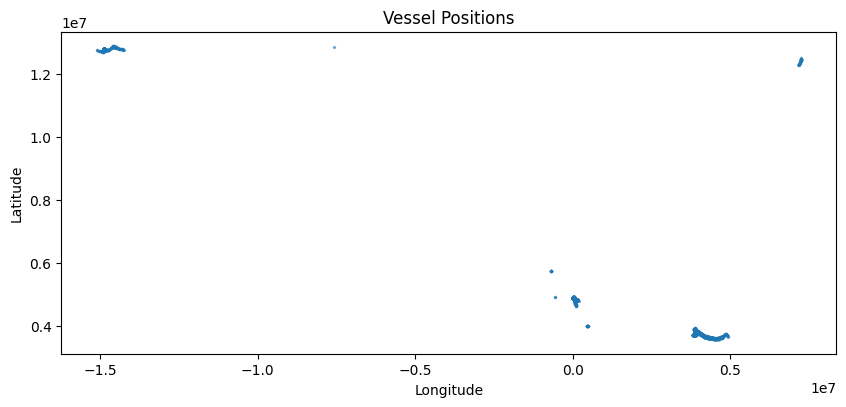

In [75]:
# Plot vessel positions using GeoPandas
import matplotlib.pyplot as plt

proximity_gdf["geometry"].plot(markersize=2, figsize=(10, 10), alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title('Vessel Positions')
plt.show()


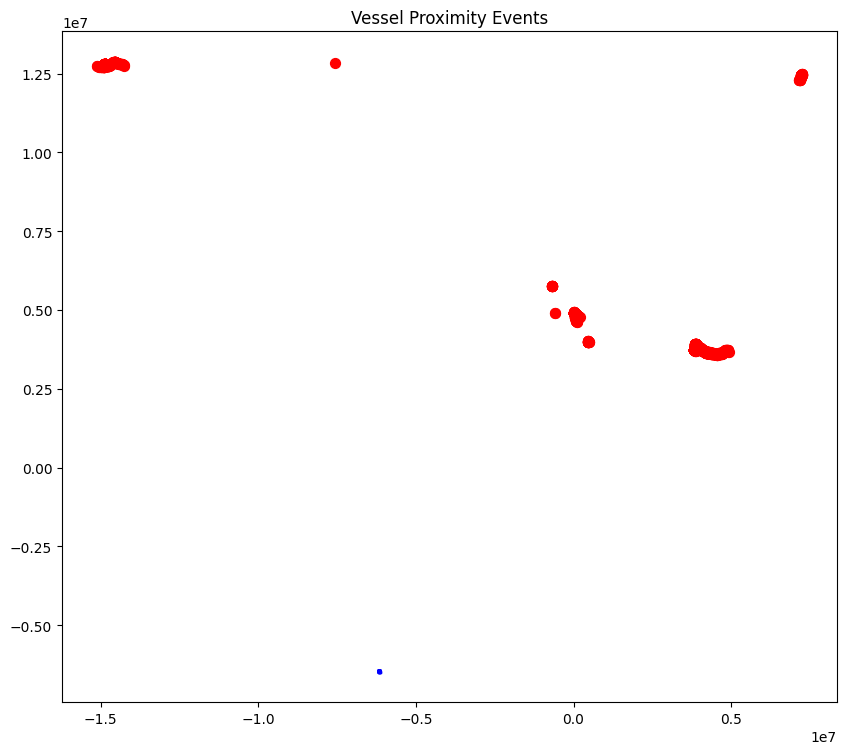

In [72]:
# Plot all vessel positions
fig, ax = plt.subplots(figsize=(10, 10))
base = gdf_projected.plot(ax=ax, color='blue', markersize=5, alpha=0.5)

# Plot proximity events in red
proximity_gdf.plot(ax=base, color='red', markersize=50)
plt.title('Vessel Proximity Events')
plt.show()